In [144]:
# import:
import random
import itertools
import math
import matplotlib.pyplot as plt
from os import stat
import numpy as np

# indexing:
STARTING = 0
DESTINATION = 1
COLUMN = 0
ROW = 1

# adjustable variables:
n_cols = 17                                     # +2 for the "standing" slot        # number of columns of the street
n_rows = 17                                                                         # number of rows of the street
num_of_pedestrian = 60                                                              # number of pedestrians
sl_coverage = 1                                                                     # street light coverage area (excluding the light)
md_coverage = 1                                                                     # motion detection coverage area (excluding the light)
brightness_lvl_lowest = 1                                                           # lowest brightness level
brightness_lvl_highest = 4                                                          # highest brightness level
nl_opt = [[1],[0],[1]]
actions_delay = 3                                                                   # natural light level (3 = darkest)
episodes = 10                                                                    # total number of episodes
alpha = 0.1                                                                         # learning rate
gamma = 0.9                                                                         # discount factor
custom_gamma = 0
custom_episodes = int(episodes//15)
epsilon_decay = 0.9999
# bounded variables:
positions = [(0, int(round((n_rows-1)/3))), (0, int(round((n_rows-1)*2/3))), \
            (0, int(round((n_cols-1)/3))), (0, int(round((n_cols-1)*2/3))), \
            (int(round((n_rows-1)/3)), 0), (int(round((n_rows-1)*2/3)), 0), \
            (int(round((n_cols-1)/3)), 0), (int(round((n_cols-1)*2/3)), 0)]                   # number of end points
tds = list(range(1, int((num_of_pedestrian + 1)//4)))                               # list of time delay
brightness_lvl = list(range(brightness_lvl_lowest, (brightness_lvl_highest + 1)))   # list of brightness level

In [145]:
class PedestriansMaker():
    
    def __init__(self, n_cols, n_rows, positions, num_of_pedestrian, tds):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.positions = positions
        self.num_of_pedestrian = num_of_pedestrian
        self.tds = tds
        self.list_sd = self.create_starting_destination(self.positions)
        self.pedestrians_sd = self.create_pedestrians_sd(self.num_of_pedestrian, self.list_sd)
        self.pedestrians_s = self.pedestrians_sd[STARTING]
        self.pedestrians_d = self.pedestrians_sd[DESTINATION]
        self.pedestrians_pathway = self.create_pathway(self.pedestrians_s, self.pedestrians_d)
        self.pedestrians_td = self.create_pedestrians_td(self.pedestrians_s, self.tds)
  
    @staticmethod
    def create_starting_destination(positions):
        starting_pt = positions # since list mentioned in the init method, can we put self.positions?
        destination_pt = positions
        list_sd = []
        for starting, destination in itertools.product(starting_pt, destination_pt):
            if starting != destination:
                list_sd.append((starting, destination))
        return list_sd # return a list of tuple [starting destination option]

    @staticmethod
    def create_pedestrians_sd(num_of_pedestrian, list_sd):
        pedestrian_s = []
        pedestrian_d = []
        for idx_pedestrian_starting in range(num_of_pedestrian):
            pedestrian_sd = random.choice(list_sd)
            pedestrian_s.append(pedestrian_sd[STARTING])
            pedestrian_d.append(pedestrian_sd[DESTINATION])
            pedestrians_sd = [pedestrian_s, pedestrian_d]
        return pedestrians_sd # return list of tuple [starting][destination]
    
    @staticmethod
    def create_pathway(pedestrians_s, pedestrians_d):
        pedestrians_pathway = []
        for idx_pedestrian in range(len(pedestrians_s)):
            pedestrian_s = pedestrians_s[idx_pedestrian]
            pedestrian_d = pedestrians_d[idx_pedestrian]
            pathway_len = tuple(np.subtract(pedestrian_d, pedestrian_s))
            pathway_len_col = pathway_len[COLUMN]
            pathway_len_row = pathway_len[ROW]
            pathway = ()
            if pathway_len_col == 0:
                pathway = pathway + (0,)
            else:
                pathway = pathway + (int(pathway_len_col/abs(pathway_len_col)),)
            if pathway_len_row == 0:
                pathway = pathway + (0,)
            else:
                pathway = pathway + (int(pathway_len_row/abs(pathway_len_row)),)
            pedestrians_pathway.append(pathway)
        return pedestrians_pathway # return the direction of a pedestrian

    @staticmethod
    def create_pedestrians_td(pedestrians_s, tds):
        pedestrians_td = []
        for idx_pedestrian in range(len(pedestrians_s)):
            pedestrians_td.append(random.choice(tds))
        return pedestrians_td # return the list of pedestrians' time delay
    
    @staticmethod
    def pedestrian_loc_update(n_cols, n_rows, list_current_pedestrian, pedestrians_pathway, pedestrians_s, pedestrians_d, pedestrians_td, time):
        updated_pedestrian_loc = []
        for idx_pedestrian in range(len(pedestrians_pathway)):
            pedestrian_loc = list_current_pedestrian[idx_pedestrian]
            pedestrian_col = pedestrian_loc[COLUMN]
            pedestrian_row = pedestrian_loc[ROW]
            pedestrian_pathway = pedestrians_pathway[idx_pedestrian]
            pedestrian_pathway_col = pedestrian_pathway[COLUMN]
            pedestrian_pathway_row = pedestrian_pathway[ROW]
            pedestrian_s = pedestrians_s[idx_pedestrian]
            pedestrian_s_col = pedestrian_s[COLUMN]
            pedestrian_s_row = pedestrian_s[ROW]
            pedestrian_d = pedestrians_d[idx_pedestrian]
            pedestrian_d_col = pedestrian_d[COLUMN]
            pedestrian_d_row = pedestrian_d[ROW]
            pedestrian_td = pedestrians_td[idx_pedestrian]
            if pedestrian_loc != pedestrian_d:
                if pedestrian_td <= time:
                    if pedestrian_s_col == pedestrian_d_col or pedestrian_s_row == pedestrian_d_row:
                        update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                        update_pedestrian_row = pedestrian_row + pedestrian_pathway_row
                        updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                    else:
                        if (pedestrian_s_col == int(round(n_cols-1)/3) or pedestrian_s_col == int(round(n_cols-1)*2/3)) and \
                            (pedestrian_d_row == int(round(n_rows-1)/3) or pedestrian_d_row == int(round(n_rows-1)*2/3)) or \
                            (pedestrian_d_col == int(round(n_cols-1)/3) or pedestrian_d_col == int(round(n_cols-1)*2/3)) and \
                            (pedestrian_s_row == int(round(n_rows-1)/3) or pedestrian_s_row == int(round(n_rows-1)*2/3)):
                            intersection = (pedestrian_d_col, pedestrian_s_row)
                            intersection_col = intersection[COLUMN]
                            intersection_row = intersection[ROW]
                            if pedestrian_s_col == int(round(n_cols-1)/3) or pedestrian_s_col == int(round(n_cols-1)*2/3):
                                if pedestrian_row != intersection_row:
                                    update_pedestrian_col = pedestrian_col
                                    update_pedestrian_row = pedestrian_row + pedestrian_pathway_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))  
                                else:
                                    update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                    update_pedestrian_row = pedestrian_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                            else:
                                if pedestrian_col != intersection_col:
                                    update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                    update_pedestrian_row = pedestrian_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                                else:
                                    update_pedestrian_col = pedestrian_col
                                    update_pedestrian_row = pedestrian_row + pedestrian_pathway_row 
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                        else:
                            if pedestrian_s_col == int(round(n_cols-1)/3) or pedestrian_s_col == int(round(n_cols-1)*2/3):
                                intersection1 = (pedestrian_s_col, pedestrian_s_col)
                                intersection1_col = intersection1[COLUMN]
                                intersection1_row = intersection1[ROW]
                                intersection2 = (pedestrian_d_col, pedestrian_s_col)
                                intersection2_col = intersection2[COLUMN]
                                intersection2_row = intersection2[ROW]
                                if pedestrian_row != intersection1_row and pedestrian_col != intersection2_col:
                                    update_pedestrian_col = pedestrian_col
                                    update_pedestrian_row = pedestrian_row + pedestrian_pathway_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                                elif pedestrian_row == intersection1_row and pedestrian_col != intersection2_col:
                                    update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                    update_pedestrian_row = pedestrian_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                                else:
                                    update_pedestrian_col = pedestrian_col
                                    update_pedestrian_row = pedestrian_row + pedestrian_pathway_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                            else:
                                intersection1 = (pedestrian_s_row, pedestrian_s_row)
                                intersection1_col = intersection1[COLUMN]
                                intersection1_row = intersection1[ROW]
                                intersection2 = (pedestrian_s_row, pedestrian_d_row)
                                intersection2_col = intersection2[COLUMN]
                                intersection2_row = intersection2[ROW]
                                if pedestrian_col != intersection1_col and pedestrian_row != intersection2_row:
                                    update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                    update_pedestrian_row = pedestrian_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                                elif pedestrian_col == intersection1_col and pedestrian_row != intersection2_row:
                                    update_pedestrian_col = pedestrian_col
                                    update_pedestrian_row = pedestrian_row + pedestrian_pathway_row 
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                                else:
                                    update_pedestrian_col = pedestrian_col + pedestrian_pathway_col
                                    update_pedestrian_row = pedestrian_row
                                    updated_pedestrian_loc.append((update_pedestrian_col, update_pedestrian_row))
                                
                else:
                    updated_pedestrian_loc.append((pedestrian_col, pedestrian_row))
            else:
                    updated_pedestrian_loc.append((pedestrian_col, pedestrian_row))
        return updated_pedestrian_loc # used to update the current location

class StreetLightMaker():

    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.street = self.create_street(self.n_cols, self.n_rows)
        self.all_sl_locs = self.create_sl(self.n_cols, self.n_rows, self.sl_coverage)
        self.sl_locs = self.used_sl(self.all_sl_locs, self.street)
        self.all_sls_cvrg_area = self.create_sl_coverage_area(self.n_cols, self.n_rows, self.sl_coverage, self.sl_locs)
        self.sls_cvrg_area = self.used_sl_coverage_area(self.all_sls_cvrg_area, self.street)
        self.all_mds_cvrg_area = self.create_motion_detection_area(self.n_cols, self.n_rows, self.md_coverage, self.sl_locs)
        self.mds_cvrg_area = self.used_motion_detection_area(self.all_mds_cvrg_area, self.street)

    @staticmethod
    def create_street(n_cols, n_rows):
        street = []
        for column in range(n_cols):
            for row in range(n_rows):
                coordinate = (column, row)
                if coordinate[COLUMN] == int(round((n_cols-1)/3)) or coordinate[COLUMN] == int(round((n_cols-1)*2/3)) or \
                coordinate[ROW] == int(round((n_rows-1)/3)) or coordinate[ROW] == int(round((n_rows-1)*2/3)) :
                    street.append(coordinate)
        return street 

    @staticmethod
    def create_sl(n_cols, n_rows, sl_coverage):
        n_cols = n_cols - 2
        n_rows = n_rows - 2
        sl_cols = list(range((sl_coverage+1), n_cols, (sl_coverage*2+1)))
        sl_rows = list(range((sl_coverage+1), n_rows, (sl_coverage*2+1)))
        
        if sl_cols == []:
            sl_cols = [0]

        if sl_rows == []:
            sl_rows = [0]
            
        sl_locs = []
        for col, row in itertools.product(sl_cols, sl_rows):
            sl_locs.append((col, row))
        
        return sl_locs # return a list of tuple [street light coordinate]

    @staticmethod
    def used_sl(all_sl_locs, street):
        used_sl_locs = []
        for idx_sl in range(len(all_sl_locs)):
            sl_loc = all_sl_locs[idx_sl]
            test_coor = street.count(sl_loc)
            if test_coor != 0:
                used_sl_locs.append(sl_loc)
        return used_sl_locs

    @staticmethod
    def create_sl_coverage_area(n_cols, n_rows, sl_coverage, list_sl_loc):
        list_sl_cvrg_area = []
        for idx_sl in range(len(list_sl_loc)):
            sl_loc = list_sl_loc[idx_sl]
            sl_col = sl_loc[COLUMN]
            sl_row = sl_loc[ROW]
            coverage_col = list(range((sl_col - sl_coverage), (sl_col + sl_coverage + 1)))
            coverage_row = list(range((sl_row - sl_coverage), (sl_row + sl_coverage + 1)))
            cols = list(range(1, (n_cols-1)))
            rows = list(range(1, (n_rows-1)))
            coverage_col = list(x for x in coverage_col if x in cols)
            coverage_row = list(x for x in coverage_row if x in rows)
            coverage_coor = []
            for col, row in itertools.product(coverage_col, coverage_row):
                coverage_coor.append((col, row))
            list_sl_cvrg_area.append(coverage_coor)
        return list_sl_cvrg_area # return list of list of tuple

    @staticmethod
    def used_sl_coverage_area(all_sls_cvrg_area, street):
        used_sls_cvrg_area = []
        for idx_sl in range(len(all_sls_cvrg_area)):
            sl = all_sls_cvrg_area[idx_sl]
            sl_cvrg_area = []
            for idx_cvrg in range(len(sl)):
                cvrg_coor = sl[idx_cvrg]
                test_coor = street.count(cvrg_coor)
                if test_coor != 0:
                    sl_cvrg_area.append(cvrg_coor)
            used_sls_cvrg_area.append(sl_cvrg_area)
        return used_sls_cvrg_area

    @staticmethod
    def create_motion_detection_area(n_cols, n_rows, md_coverage, list_sl_loc):
        list_md_cvrg_area = []
        for idx_sl in range(len(list_sl_loc)):
            sl_loc = list_sl_loc[idx_sl]
            sl_col = sl_loc[COLUMN]
            sl_row = sl_loc[ROW]
            coverage_col = list(range((sl_col - md_coverage), (sl_col + md_coverage + 1)))
            coverage_row = list(range((sl_row - md_coverage), (sl_row + md_coverage + 1)))
            rows = list(range(1, n_rows - 1))
            cols = list(range(1, n_cols - 1))
            coverage_row = list(x for x in coverage_row if x in rows)
            coverage_col = list(x for x in coverage_col if x in cols)
            coverage_coor = []
            for col, row in itertools.product(coverage_col, coverage_row):
                coverage_coor.append((col, row))
            list_md_cvrg_area.append(coverage_coor)
        return list_md_cvrg_area # return list of list of tuple

    @staticmethod
    def used_motion_detection_area(all_mds_cvrg_area, street):
        used_mds_cvrg_area = []
        for idx_sl in range(len(all_mds_cvrg_area)):
            sl = all_mds_cvrg_area[idx_sl]
            sl_cvrg_area = []
            for idx_cvrg in range(len(sl)):
                cvrg_coor = sl[idx_cvrg]
                test_coor = street.count(cvrg_coor)
                if test_coor != 0:
                    sl_cvrg_area.append(cvrg_coor)
            used_mds_cvrg_area.append(sl_cvrg_area)
        return used_mds_cvrg_area

class Visualization():
    
    def __init__(self, n_cols, n_rows, positions, num_of_pedestrian, tds, sl_coverage, md_coverage):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.positions = positions
        self.num_of_pedestrian = num_of_pedestrian
        self.tds = tds
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.PM_class = PedestriansMaker(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds)
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        # self.grid_pedestrians = self.create_location_grid(self.n_cols, self.n_rows, self.num_of_pedestrian, self.PM_class.pedestrians_s)
        self.grid_sls = self.create_sl_grid(self.n_cols, self.n_rows, self.SLM_class.sl_locs)
        # self.grid_brightness = self.create_brightness_grid(action, self.n_cols, self.n_rows, self.SLM_class.list_sl_cvrg_area)

    # @staticmethod
    # def create_location_grid(n_cols, n_rows, num_of_pedestrian, pedestrians_s):
    #     grid_pedestrian = []
    #     for idx_row in range(n_rows):
    #         row = []
    #         for idx_column in range(n_cols):
    #             row.append(0)
    #         grid_pedestrian.append(row)
    #     for idx_pedestrian in range(num_of_pedestrian):
    #         pedestrian_s = pedestrians_s[idx_pedestrian]
    #         grid_pedestrian[pedestrian_s[COLUMN]][pedestrian_s[ROW]] += 1
    #     return grid_pedestrian # return the grid and each pedestrian position on the grid

    @staticmethod
    def create_sl_grid(n_cols, n_rows, list_sl_loc):
        grid_sl = []
        for idx_row in range(n_rows):
            row = []
            for idx_column in range(n_cols):
                row.append(0)
            grid_sl.append(row)
        for idx_sl in range(len(list_sl_loc)):
            sl_loc = list_sl_loc[idx_sl]
            grid_sl[sl_loc[COLUMN]][sl_loc[ROW]] = 1
        return grid_sl # return the grid and each street light position on the grid

    @staticmethod
    def create_brightness_grid(action, n_cols, n_rows, list_sl_cvrg_area):
        grid_sl_brightness = []
        assert len(action) == len(list_sl_cvrg_area)
        for idx_row in range(n_rows):
            row = []
            for idx_column in range(n_cols):
                row.append(0)
            grid_sl_brightness.append(row)
        for idx_action in range(len(action)):
            sl_cvrg = list_sl_cvrg_area[idx_action]
            sl_action = action[idx_action]
            for idx_cvrg in range(len(sl_cvrg)):
                cvrg_coor = sl_cvrg[idx_cvrg]
                cvrg_col = cvrg_coor[COLUMN]
                cvrg_row = cvrg_coor[ROW]
                grid_sl_brightness[cvrg_col][cvrg_row] = sl_action
        return grid_sl_brightness # return grid for brightness

class Environment():

    def __init__(self, n_cols, n_rows, positions, num_of_pedestrian, tds, sl_coverage, md_coverage, nl_opt):
        self.time = 0
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.positions = positions
        self.num_of_pedestrian = num_of_pedestrian
        self.tds = tds
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.nl_opt = nl_opt
        self.PM_class = PedestriansMaker(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds)
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.Vis_class = Visualization(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds, self.sl_coverage, self.md_coverage)
        self.list_current_pedestrian = self.PM_class.pedestrians_s.copy()
        self.nl = self.natural_light(self.nl_opt)

    @staticmethod
    def natural_light(nl_opt):
        period_length = n_cols + max(tds) - 1
        period_1 = period_3 = math.floor(period_length*(0.2))
        period_2 = period_length - period_1 - period_3
        period = [period_1, period_2, period_3]
        nl = []
        for idx_nl in range(len(nl_opt)):
            nl.append(nl_opt[idx_nl] * period[idx_nl])
        flat_nl = [item for items in nl for item in items]
        return flat_nl

    @staticmethod
    def pedestrian_count(list_sl_cvrg_area, list_current_pedestrian):
        sl_pedestrian_count = []
        for idx_sl in range(len(list_sl_cvrg_area)):
            sl_cvrg_area = list_sl_cvrg_area[idx_sl]
            pedestrian_count = 0
            for idx_pedestrian in range(len(list_current_pedestrian)):
                current_pedestrian_loc = list_current_pedestrian[idx_pedestrian]
                test_coor = sl_cvrg_area.count((current_pedestrian_loc[COLUMN], current_pedestrian_loc[ROW]))
                pedestrian_count = pedestrian_count + test_coor
            if pedestrian_count >= 3: # will be generalized
                pedestrian_count = 3
            sl_pedestrian_count.append(pedestrian_count+1)
        return sl_pedestrian_count

    @staticmethod
    def obs(list_sl_cvrg_area, list_current_pedestrian, nl, time):
        list_pedestrian_detected = [nl[time]]
        for idx_sl in range(len(list_sl_cvrg_area)):
            sl_cvrg_area = list_sl_cvrg_area[idx_sl]
            test_coor = 0
            for idx_pedestrian in range(len(list_current_pedestrian)):
                current_pedestrian_loc = list_current_pedestrian[idx_pedestrian]
                pedestrian_count = sl_cvrg_area.count((current_pedestrian_loc[COLUMN], current_pedestrian_loc[ROW]))
                test_coor = test_coor + pedestrian_count
            if test_coor == 0:
                list_pedestrian_detected.append(test_coor)
            else:
                list_pedestrian_detected.append(1)
        return list_pedestrian_detected
    
    @staticmethod
    def reward(actions, sl_pedestrian_count, nl, time):
        reward_sl = []
        for idx_sl in range(len(actions)):
            sl_action = actions[idx_sl]
            pedestrian_count = sl_pedestrian_count[idx_sl]
            sl_reward = - abs(pedestrian_count - (sl_action + nl[time]))
            reward_sl.append(sl_reward) 
        reward = sum(reward_sl)
        return reward

    @staticmethod
    def done(list_current_pedestrian, pedestrians_d):
        status = []
        for idx_pedestrian in range(len(list_current_pedestrian)):
            current_pedestrian_loc = list_current_pedestrian[idx_pedestrian]
            pedestrian_d = pedestrians_d[idx_pedestrian]
            if current_pedestrian_loc == pedestrian_d:
                status.append(True)
            else:
                status.append(False)
        done = all(status)
        return done

    @staticmethod
    def info():
        pass

    def reset(self):
        self.time = 0
        self.PM_class = PedestriansMaker(self.n_cols, self.n_rows, self.positions, self.num_of_pedestrian, self.tds)
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.list_current_pedestrian = self.PM_class.pedestrians_s.copy()
        list_pedestrian_detected = self.obs(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian, self.nl, self.time)
        return list_pedestrian_detected

    def step(self, actions):
        self.time = self.time + 1
        self.list_current_pedestrian = self.PM_class.pedestrian_loc_update(self.n_cols, self.n_rows, self.list_current_pedestrian, self.PM_class.pedestrians_pathway, self.PM_class.pedestrians_s, self.PM_class.pedestrians_d, self.PM_class.pedestrians_td, self.time)
        list_pedestrian_detected = self.obs(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian, self.nl, self.time)
        done = self.done(self.list_current_pedestrian, self.PM_class.pedestrians_d)
        reward = self.reward(actions, self.pedestrian_count(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian), self.nl, self.time)
        info = {
            'time' : self.time,
            'actions' : actions,
            'sl pedestrian count' : self.pedestrian_count(self.SLM_class.sls_cvrg_area, self.list_current_pedestrian),
        }
        return list_pedestrian_detected, done, reward, info # info will be added later

    def render(self):
        grid = []
        for rows in self.Vis_class.grid_pedestrians:
            grid.append(rows)
        return grid

In [140]:
sim3_pm = PedestriansMaker(n_cols, n_rows, positions, num_of_pedestrian, tds)
a = sim3_pm.pedestrians_s[3]
print(a)

5


In [146]:
# non delay action | random
class Agent_ndR():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(np.random.choice(brightness_lvl))
        return actions

# non delay action | always 1
class Agent_nd1():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(1)
        return actions

# non delay action | always 2
class Agent_nd2():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(2)
        return actions

# non delay action | always 3
class Agent_nd3():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(3)
        return actions

# non delay action | always 4
class Agent_nd4():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            actions.append(4)
        return actions

# non delay action | 0-1 and 1-2
class Agent_nd12():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(2)
        return actions

# non delay action | 0-1 and 1-3
class Agent_nd13():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(3)
        return actions

# non delay action | 0-1 and 1-4
class Agent_nd14():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(4)
        return actions

# non delay action | 0-1 and 1-5
# class Agent_AZ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(5)
        return actions

# non delay action | qlearning
class Agent_ndQ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(self.brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        state_idx = self.state_idx(obs)
        actions_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
        actions = self.idx_action(actions_idx, list_sl_loc, brightness_lvl)
        return actions

# non delay action | qlearning epsilon-greedy    
class Agent_ndQe():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(self.brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        actions = []
        if rnd < epsilon:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(np.random.choice(brightness_lvl))
        else:
            state_idx = self.state_idx(obs)
            actions_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
            actions = self.idx_action(actions_idx, list_sl_loc, brightness_lvl)
        return actions

# delay action | random
class Agent_dR():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(np.random.choice(brightness_lvl))
        else:
            actions = old_actions
        return actions

# delay action | always 1
class Agent_d1():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(1)
        else:
            actions = old_actions
        return actions

# delay action | always 2
class Agent_d2():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(2)
        else:
            actions = old_actions
        return actions

# delay action | always 3
class Agent_d3():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(3)
        else:
            actions = old_actions
        return actions

# delay action | always 4
class Agent_d4():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(4)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-2
class Agent_d12():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(2)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-3
class Agent_d13():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(3)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-4
class Agent_d14():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(4)
        else:
            actions = old_actions
        return actions

# delay action | qlearning
class Agent_dQ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(self.brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            state_idx = self.state_idx(obs)
            action_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
            actions = self.idx_action(action_idx, list_sl_loc, brightness_lvl)
        else:
            actions = old_actions
        return actions

# delay action | qlearning epsilon-greedy 
class Agent_dQe():
        
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = max(brightness_lvl) ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions, brightness_lvl):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (max(brightness_lvl) ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs, brightness_lvl):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions, brightness_lvl)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            if rnd < epsilon:
                for idx_sl in range(len(list_sl_loc)):
                    actions.append(np.random.choice(brightness_lvl))
            else:
                state_idx = self.state_idx(obs)
                action_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
                actions = self.idx_action(action_idx, list_sl_loc, brightness_lvl)
        else:
            actions = old_actions
        return actions

In [147]:
sim3_pm = PedestriansMaker(n_cols, n_rows, positions, num_of_pedestrian, tds)
sim3_slm = StreetLightMaker(n_rows, n_cols, sl_coverage, md_coverage)
sim3_env = Environment(n_cols, n_rows, positions, num_of_pedestrian, tds, sl_coverage, md_coverage, nl_opt)

sim3_agent_ndR = Agent_ndR(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd1 = Agent_nd1(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd2 = Agent_nd2(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd3 = Agent_nd3(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd4 = Agent_nd4(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd12 = Agent_nd12(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd13 = Agent_nd13(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_nd14 = Agent_nd14(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_ndQ = Agent_ndQ(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_ndQe = Agent_ndQe(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)

sim3_agent_dR = Agent_dR(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d1 = Agent_d1(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d2 = Agent_d2(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d3 = Agent_d3(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d4 = Agent_d4(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d12 = Agent_d12(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d13 = Agent_d13(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_d14 = Agent_d14(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_dQ = Agent_dQ(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
sim3_agent_dQe = Agent_dQe(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)

MemoryError: Unable to allocate 4.00 PiB for an array with shape (131072, 4294967296) and data type float64

In [56]:
# non delay action | qlearning epsilon-greedy    
class Agent_AV():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        actions = []
        if rnd < epsilon:
            for idx_sl in range(len(list_sl_loc)):
                actions.append(np.random.choice(brightness_lvl))
        else:
            state_idx = self.state_idx(obs)
            actions_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
            actions = self.idx_action(actions_idx, list_sl_loc, brightness_lvl)
        return actions

# non delay action | 0-1 and 1-2
class Agent_AW():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(2)
        return actions

# non delay action | 0-1 and 1-3
class Agent_AX():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(3)
        return actions

# non delay action | 0-1 and 1-4
class Agent_AY():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(4)
        return actions

# non delay action | 0-1 and 1-5
class Agent_AZ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, action, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(action)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        actions = []
        for idx_sl in range(len(list_sl_loc)):
            if obs[idx_sl] == 0:
                actions.append(1)
            else:
                actions.append(5)
        return actions

# delay action | qlearning epsilon-greedy 
class Agent_BV():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs, brightness_lvl): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % max(brightness_lvl)
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // max(brightness_lvl)
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            if rnd < epsilon:
                for idx_sl in range(len(list_sl_loc)):
                    actions.append(np.random.choice(brightness_lvl))
            else:
                state_idx = self.state_idx(obs)
                action_idx = np.random.choice(np.flatnonzero(qtable[state_idx, :] == qtable[state_idx, :].max()))
                actions = self.idx_action(action_idx, list_sl_loc, brightness_lvl)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-2
class Agent_BW():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(2)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-3
class Agent_BX():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(3)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-4
class Agent_BY():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(4)
        else:
            actions = old_actions
        return actions

# delay action | 0-1 and 1-5
class Agent_BZ():
    
    def __init__(self, n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.sl_coverage = sl_coverage
        self.md_coverage = md_coverage
        self.brightness_lvl = brightness_lvl
        self.actions_delay = actions_delay
        self.SLM_class = StreetLightMaker(self.n_cols, self.n_rows, self.sl_coverage, self.md_coverage)
        self.state_space = 2 ** (len(self.SLM_class.sl_locs)+1)
        self.action_space = 5 ** len(self.SLM_class.sl_locs)
        self.qtable = np.zeros([self.state_space, self.action_space])
    
    @staticmethod
    def state_idx(state):
        state_bin = ''.join(map(str,state))
        state_idx = 0
        for idx in range(len(state_bin)):
            i = len(state_bin) - 1 - idx
            state_idx += int(state_bin[i]) * (2 ** idx)
        return state_idx

    @staticmethod
    def idx_state(state_idx, list_sl_loc):
        state = np.zeros(len(list_sl_loc+1))
        state_bin = list(bin(state_idx))
        del state_bin[0:2]
        state_bin = list(map(int, state_bin))
        for idx_bin in range(len(state_bin)):
            state_len = len(list_sl_loc+1)
            idx = state_len - 1 - idx_bin
            idx_bin = len(state_bin) - 1 - idx_bin
            state[idx] = state_bin[idx_bin]
        return state

    @staticmethod
    def action_idx(actions):
        actions_copy = np.array(actions)
        actions_copy.fill(1)
        actions_update = actions - actions_copy
        actions_ter = ''.join(map(str, actions_update))
        actions_idx = 0
        for idx in range(len(actions_ter)):
            i = len(actions_ter) - 1 - idx
            actions_idx += int(actions_ter[i]) * (5 ** idx)
        return actions_idx

    @staticmethod
    def idx_action(actions_idx, sl_locs): # currently not used
        actions_ter = np.zeros(len(sl_locs))
        current_idx = actions_idx
        for idx in range(len(actions_ter)):
            reminder = current_idx % 5
            actions_ter[len(actions_ter) - 1 - idx] = reminder
            current_idx = current_idx // 5
        action_copy = np.array(actions_ter)
        action_copy.fill(1)
        action = actions_ter + action_copy
        return list(map(int, action))
        
    def learn(self, qtable, obs, actions, alpha, gamma, reward, new_obs):
        state_idx = self.state_idx(obs)
        action_idx = self.action_idx(actions)
        new_state_idx = self.state_idx(new_obs)
        old_value = qtable[state_idx, action_idx]
        qtable[state_idx, action_idx] = old_value + (alpha * (reward + (gamma * np.max(qtable[new_state_idx, :])) - old_value))
        return qtable

    def action(self, actions, time, actions_delay, qtable, obs, list_sl_loc, brightness_lvl, epsilon):
        rnd = np.random.random()
        old_actions = actions
        actions = []
        if time % self.actions_delay == 0:
            for idx_sl in range(len(list_sl_loc)):
                if obs[idx_sl] == 0:
                    actions.append(1)
                else:
                    actions.append(5)
        else:
            actions = old_actions
        return actions

In [57]:
pm = PedestriansMaker(n_cols, n_rows, positions, num_of_pedestrian, tds, intersection)
slm = StreetLightMaker(n_rows, n_cols, sl_coverage, md_coverage)
env = Environment(n_cols, n_rows, positions, num_of_pedestrian, tds, intersection, sl_coverage, md_coverage, nl_opt)
agent_av = Agent_AV(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_aw = Agent_AW(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_ax = Agent_AX(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_ay = Agent_AY(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_az = Agent_AZ(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_bv = Agent_BV(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_bw = Agent_BW(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_bx = Agent_BX(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_by = Agent_BY(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)
agent_bz = Agent_BZ(n_cols, n_rows, sl_coverage, md_coverage, brightness_lvl, actions_delay)

final test - non delay action | qlearning epsilon-greedy


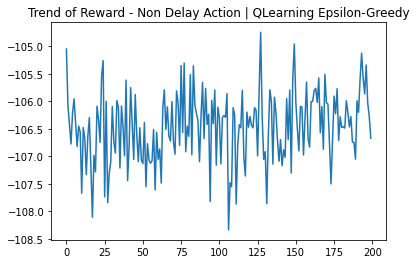

In [44]:
random.seed(21)
print('final test - non delay action | qlearning epsilon-greedy')

qtable = agent_av.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_av.action(qtable, obs, agent_av.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_av.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_mean_av = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_av.append(mean)

epsilons_av = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(epsilons[idx : idx + 200])
    epsilons_av.append(mean)

plt.plot(list(range(len(rewards_mean_av))), rewards_mean_av)
plt.title("Trend of Reward - Non Delay Action | QLearning Epsilon-Greedy")
plt.show()

final test - non delay action | 0-1 and 1-2


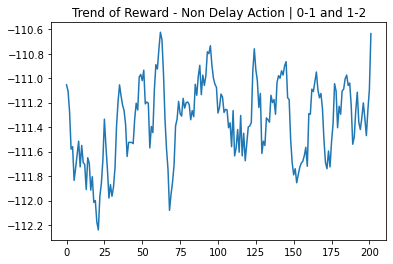

In [45]:
random.seed(21)
print('final test - non delay action | 0-1 and 1-2')

qtable = agent_aw.qtable
epsilon = 1
full_actions = []
full_rewards = []
for i in range(custom_episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_aw.action(qtable, obs, agent_aw.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_aw.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)

rewards_mean_aw = []
for idx in range(0, custom_episodes, custom_episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_aw.append(mean)

plt.plot(list(range(len(rewards_mean_aw))), rewards_mean_aw)
plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-2")
plt.show()

final test - non delay action | 0-1 and 1-3


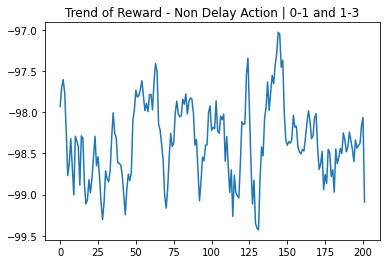

In [46]:
random.seed(21)
print('final test - non delay action | 0-1 and 1-3')

qtable = agent_ax.qtable
epsilon = 1
full_actions = []
full_rewards = []
for i in range(custom_episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_ax.action(qtable, obs, agent_ax.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_ax.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)

rewards_mean_ax = []
for idx in range(0, custom_episodes, custom_episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_ax.append(mean)

plt.plot(list(range(len(rewards_mean_ax))), rewards_mean_ax)
plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-3")
plt.show()

final test - non delay action | 0-1 and 1-4


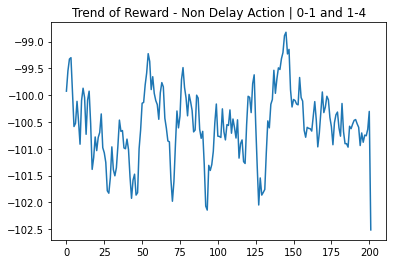

In [47]:
random.seed(21)
print('final test - non delay action | 0-1 and 1-4')

qtable = agent_ay.qtable
epsilon = 1
full_actions = []
full_rewards = []
for i in range(custom_episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_ay.action(qtable, obs, agent_ay.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_ay.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)

rewards_mean_ay = []
for idx in range(0, custom_episodes, custom_episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_ay.append(mean)

plt.plot(list(range(len(rewards_mean_ay))), rewards_mean_ay)
plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-4")
plt.show()

In [48]:
# random.seed(21)
# print('final test - non delay action | 0-1 and 1-5')

# qtable = agent_az.qtable
# epsilon = 1
# full_actions = []
# full_rewards = []
# for i in range(custom_episodes):
#     total_reward = 0
#     done = False
#     obs = env.reset()
#     episode_actions = []
#     epsilon = epsilon * epsilon_decay
#     while not done:
#         actions = agent_az.action(qtable, obs, agent_az.SLM_class.sl_locs, brightness_lvl, epsilon)
#         new_obs, done, reward, info = env.step(actions)
#         total_reward += reward
#         qtable = agent_az.learn(qtable, obs, actions, alpha, custom_gamma, reward, new_obs)
#         obs = new_obs
#         episode_actions.append(",".join([str(x) for x in actions]))
#     full_actions.append("|".join([str(x) for x in episode_actions]))
#     full_rewards.append(total_reward)

# rewards_mean_az = []
# for idx in range(0, custom_episodes, custom_episodes//200):
#     mean = np.mean(full_rewards[idx : idx + 200])
#     rewards_mean_az.append(mean)

# plt.plot(list(range(len(rewards_mean_az))), rewards_mean_az)
# plt.title("Trend of Reward - Non Delay Action | 0-1 and 1-5")
# plt.show()

final test - delay action | qlearning epsilon-greedy


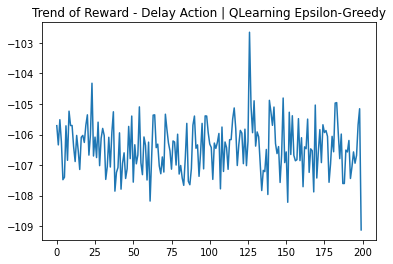

In [49]:
random.seed(21)
print('final test - delay action | qlearning epsilon-greedy')

qtable = agent_bv.qtable
epsilon = 1
full_actions = []
full_rewards = []
epsilons = []
for i in range(episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    actions = [1 for _ in range(len(agent_bv.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_bv.action(actions, env.time, actions_delay, qtable, obs, agent_bv.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_bv.learn(qtable, obs, actions, alpha, gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)
    epsilons.append(epsilon)

rewards_mean_bv = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_bv.append(mean)

epsilons_bv = []
for idx in range(0, episodes, episodes//200):
    mean = np.mean(epsilons[idx : idx + 200])
    epsilons_bv.append(mean)

plt.plot(list(range(len(rewards_mean_bv))), rewards_mean_bv)
plt.title("Trend of Reward - Delay Action | QLearning Epsilon-Greedy")
plt.show()

final test - delay action | 0-1 and 1-2


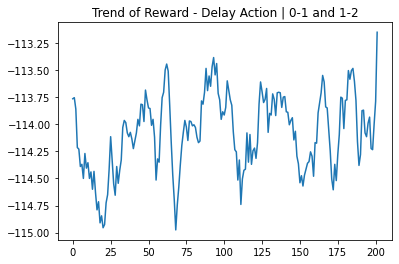

In [50]:
random.seed(21)
print('final test - delay action | 0-1 and 1-2')

qtable = agent_bw.qtable
epsilon = 1
full_actions = []
full_rewards = []
for i in range(custom_episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    actions = [1 for _ in range(len(agent_bw.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_bw.action(actions, env.time, actions_delay, qtable, obs, agent_bw.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_bw.learn(qtable, obs, actions, alpha, gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)

rewards_mean_bw = []
for idx in range(0, custom_episodes, custom_episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_bw.append(mean)

plt.plot(list(range(len(rewards_mean_bw))), rewards_mean_bw)
plt.title("Trend of Reward - Delay Action | 0-1 and 1-2")
plt.show()

final test - delay action | 0-1 and 1-3


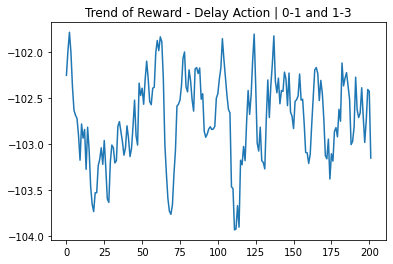

In [51]:
random.seed(21)
print('final test - delay action | 0-1 and 1-3')

qtable = agent_bx.qtable
epsilon = 1
full_actions = []
full_rewards = []
for i in range(custom_episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    actions = [1 for _ in range(len(agent_bx.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_bx.action(actions, env.time, actions_delay, qtable, obs, agent_bx.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_bx.learn(qtable, obs, actions, alpha, gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)

rewards_mean_bx = []
for idx in range(0, custom_episodes, custom_episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_bx.append(mean)

plt.plot(list(range(len(rewards_mean_bx))), rewards_mean_bx)
plt.title("Trend of Reward - Delay Action | 0-1 and 1-3")
plt.show()

final test - delay action | 0-1 and 1-4


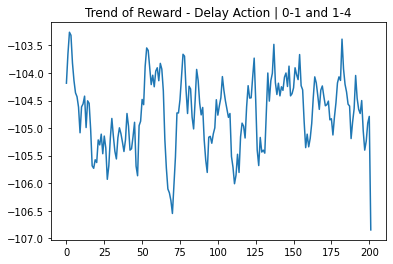

In [52]:
random.seed(21)
print('final test - delay action | 0-1 and 1-4')

qtable = agent_by.qtable
epsilon = 1
full_actions = []
full_rewards = []
for i in range(custom_episodes):
    total_reward = 0
    done = False
    obs = env.reset()
    actions = [1 for _ in range(len(agent_by.SLM_class.sl_locs))]
    episode_actions = []
    epsilon = epsilon * epsilon_decay
    while not done:
        actions = agent_by.action(actions, env.time, actions_delay, qtable, obs, agent_by.SLM_class.sl_locs, brightness_lvl, epsilon)
        new_obs, done, reward, info = env.step(actions)
        total_reward += reward
        qtable = agent_by.learn(qtable, obs, actions, alpha, gamma, reward, new_obs)
        obs = new_obs
        episode_actions.append(",".join([str(x) for x in actions]))
    full_actions.append("|".join([str(x) for x in episode_actions]))
    full_rewards.append(total_reward)

rewards_mean_by = []
for idx in range(0, custom_episodes, custom_episodes//200):
    mean = np.mean(full_rewards[idx : idx + 200])
    rewards_mean_by.append(mean)

plt.plot(list(range(len(rewards_mean_by))), rewards_mean_by)
plt.title("Trend of Reward - Delay Action | 0-1 and 1-4")
plt.show()

In [53]:
# random.seed(21)
# print('final test - delay action | 0-1 and 1-5')

# qtable = agent_bz.qtable
# epsilon = 1
# full_actions = []
# full_rewards = []
# for i in range(custom_episodes):
#     total_reward = 0
#     done = False
#     obs = env.reset()
#     actions = [1 for _ in range(len(agent_bz.SLM_class.sl_locs))]
#     episode_actions = []
#     epsilon = epsilon * epsilon_decay
#     while not done:
#         actions = agent_bz.action(actions, env.time, actions_delay, qtable, obs, agent_bz.SLM_class.sl_locs, brightness_lvl, epsilon)
#         new_obs, done, reward, info = env.step(actions)
#         total_reward += reward
#         qtable = agent_bz.learn(qtable, obs, actions, alpha, gamma, reward, new_obs)
#         obs = new_obs
#         episode_actions.append(",".join([str(x) for x in actions]))
#     full_actions.append("|".join([str(x) for x in episode_actions]))
#     full_rewards.append(total_reward)

# rewards_mean_bz = []
# for idx in range(0, custom_episodes, custom_episodes//200):
#     mean = np.mean(full_rewards[idx : idx + 200])
#     rewards_mean_bz.append(mean)

# plt.plot(list(range(len(rewards_mean_bz))), rewards_mean_bz)
# plt.title("Trend of Reward - Delay Action | 0-1 and 1-5")
# plt.show()

/var/folders/qn/9bbd28_j67g33m6x99411d1w0000gn/T/ipykernel_772/2121695746.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_1.show()


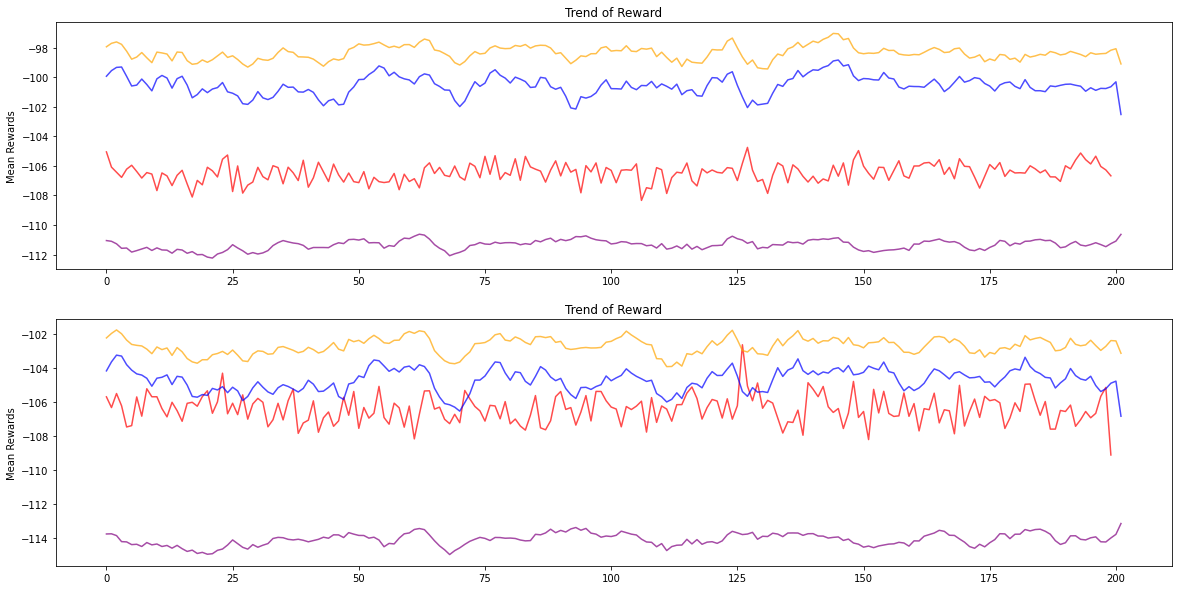

In [54]:
av = rewards_mean_av
aw = rewards_mean_aw
ax_x = rewards_mean_ax
ay = rewards_mean_ay
# az = rewards_mean_az
bv = rewards_mean_bv
bw = rewards_mean_bw
bx = rewards_mean_bx
by = rewards_mean_by
# bz = rewards_mean_bz

fig_1, ax_1 = plt.subplots(nrows = 2, ncols=1, figsize=(20, 10))

ax_1[0].plot(list(range(len(av))), av, color = "red", alpha = 0.7)
ax_1[0].plot(list(range(len(aw))), aw, color = "purple", alpha = 0.7)
ax_1[0].plot(list(range(len(ax_x))), ax_x, color = "orange", alpha = 0.7)
ax_1[0].plot(list(range(len(ay))), ay, color = "blue", alpha = 0.7)
# ax_1[0].plot(list(range(len(az))), az, color = "green", alpha = 0.7)
ax_1[0].set_title("Trend of Reward")
ax_1[0].set_ylabel("Mean Rewards")

ax_1[1].plot(list(range(len(bv))), bv, color = "red", alpha = 0.7)
ax_1[1].plot(list(range(len(bw))), bw, color = "purple", alpha = 0.7)
ax_1[1].plot(list(range(len(bx))), bx, color = "orange", alpha = 0.7)
ax_1[1].plot(list(range(len(by))), by, color = "blue", alpha = 0.7)
# ax_1[1].plot(list(range(len(bz))), bz, color = "green", alpha = 0.7)
ax_1[1].set_title("Trend of Reward")
ax_1[1].set_ylabel("Mean Rewards")

fig_1.show()

In [55]:
# epsilons_av = epsilons_av
# epsilons_bv = epsilons_bv

# fig_2, ax_2 = plt.subplots(nrows = 1, ncols=1, figsize=(20, 10))

# ax_2[0].plot(list(range(len(epsilons_av))), epsilons_av, color = "red", alpha = 0.7)
# ax_2[0].plot(list(range(len(epsilons_bv))), epsilons_bv, color = "purple", alpha = 0.7)
# ax_2[0].set_title("Trend of Epsilons")
# ax_2[0].set_ylabel("Epsilon Value")

# fig_2.show()